# Business Understanding

Everyone has their own morning routine. As a developer, I am not sure whether my wake up is normal compared to other developers. I found this data from Stack Overflow's developer survey from 2018 showing respondents' wake times, which really intrigued me. I want to dig deeper into it and see what insights I can find. Below are a few questions I came up with and I will try to answer them in this Jupyter book.

1. In which country do developers get up early?
2. Do people using different programming languages wake up at different times?
3. Does wake up time have an effect on job satisfaction?
4. Do people getting up at different times earn different?

# Data Understanding

In [1]:
# Import libaries
import zipfile
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18, 5]

## Gather Data

Data source: 2018 in https://insights.stackoverflow.com/survey

In [2]:
df = pd.read_csv(zipfile.ZipFile('data/developer_survey_2018.zip').open('survey_results_public.csv'), error_bad_lines=False, index_col=False, dtype='unicode')

## Assess Data

In [3]:
df.describe()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
count,98855,98855,98855,98443,94901,95321,94703,79036,71531,92098,...,72108,64469,59765,61813,57473,64574,62596,15781,65941,65879
unique,98855,2,2,183,3,6,9,12,8,9568,...,4,15,14,9,71,7,2,2,3,5
top,75788,Yes,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",20 to 99 employees,Back-end developer,...,I don't typically exercise,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,25 - 34 years old,No,No,The survey was an appropriate length,Somewhat easy
freq,1,79897,55769,20309,70399,70495,43659,50336,16996,6417,...,26995,59458,55013,18090,40541,31759,44478,15043,33257,24434


In [4]:
df['WakeTime'].value_counts()

Between 7:01 - 8:00 AM          21250
Between 6:01 - 7:00 AM          20322
Between 8:01 - 9:00 AM          10592
Between 5:00 - 6:00 AM           8922
I do not have a set schedule     3842
Between 9:01 - 10:00 AM          3453
Before 5:00 AM                   1730
Between 10:01 - 11:00 AM         1020
Between 11:01 AM - 12:00 PM       387
I work night shifts               327
After 12:01 PM                    301
Name: WakeTime, dtype: int64

In [5]:
ordered_wake_time = ["I work night shifts",
                     "Before 5:00 AM", 
                       "Between 5:00 - 6:00 AM", 
                       "Between 6:01 - 7:00 AM",
                       "Between 7:01 - 8:00 AM",
                       "Between 8:01 - 9:00 AM",
                       "Between 9:01 - 10:00 AM",
                       "Between 10:01 - 11:00 AM",
                       "Between 11:01 AM - 12:00 PM",
                       "After 12:01 PM"]

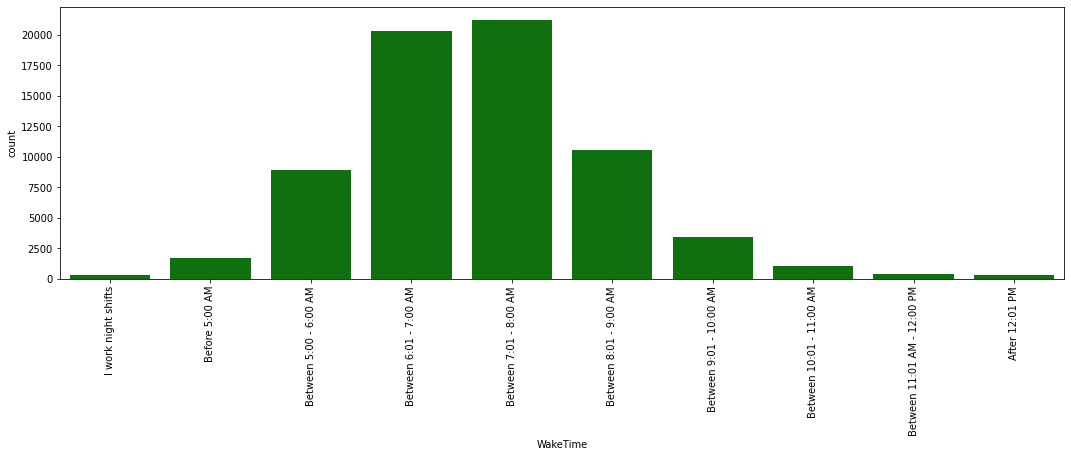

In [6]:
# Visualize wake time counts
sns.countplot(x='WakeTime', order=ordered_wake_time, data=df, color='g')
plt.xticks(rotation=90)
plt.show()

# Data Preparation

### Clean Data

In [7]:
# Only keep the status of working remotely, the country, job satisfaction, programming language used, Salary converted to annual USD
cols = ['WakeTime', 'Country', 'JobSatisfaction', 'LanguageWorkedWith', 'ConvertedSalary']
df = df[cols]

In [8]:
# Drop the record if its wake time is missing
df = df.dropna(subset=['WakeTime'], axis=0)

In [9]:
# Make dummy vairbales for programming languages
languages = ['JavaScript','SQL','Java','C#','Python','PHP','CSS','HTML','C++','C','Bash/Shell','Ruby','TypeScript','Objective-C',
             'Node.js','Swift','AngularJS','Visual','Basic','Go','R','Matlab', 'VB.NET', 'Kotlin']

for language in languages:
    dummay_language = lambda row: True if not pd.isnull(row['LanguageWorkedWith']) \
    and language in row['LanguageWorkedWith'].split(';') else False
    df[language] = df.apply(dummay_language, axis=1)

# Answers To Questions
## Analyze, model and visualize data

## Q1 - In which country do developers get up early?

In [10]:
# For this question, we only consider the top 10 countries with the most survey responses
df_country = df[df['Country'].isin(list(df['Country'].value_counts().index[:10]))]

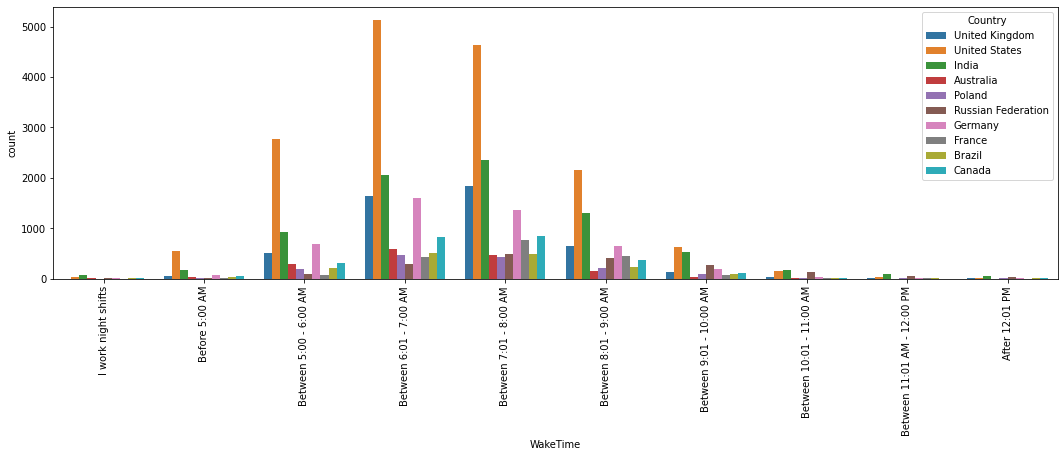

In [11]:
# Check counts of each country by wake time
sns.countplot(x='WakeTime', order=ordered_wake_time, hue='Country',
              data=df_country
             )
plt.xticks(rotation=90)
plt.show()

The Bar plot above indicates that each country has a similar distribution that wake up times tend toward the time around  6-8 AM. However, it is not comparable as the number of respondents in each country could be very different. Thus, we need to calculate the percentage.

In [12]:
# Calculate the percentage of responses for wake time of each country
country_counts = df_country.groupby('Country')['WakeTime'].count()
df_country_perc = df_country.groupby(['Country', 'WakeTime'])\
                     .size().div(country_counts, level='Country').reset_index().rename(columns={0: 'Percentage'})
df_country_perc.head()

,Country,WakeTime,Percentage
0,Australia,After 12:01 PM,0.000609
1,Australia,Before 5:00 AM,0.024375
2,Australia,Between 10:01 - 11:00 AM,0.006094
3,Australia,Between 5:00 - 6:00 AM,0.176112
4,Australia,Between 6:01 - 7:00 AM,0.357099


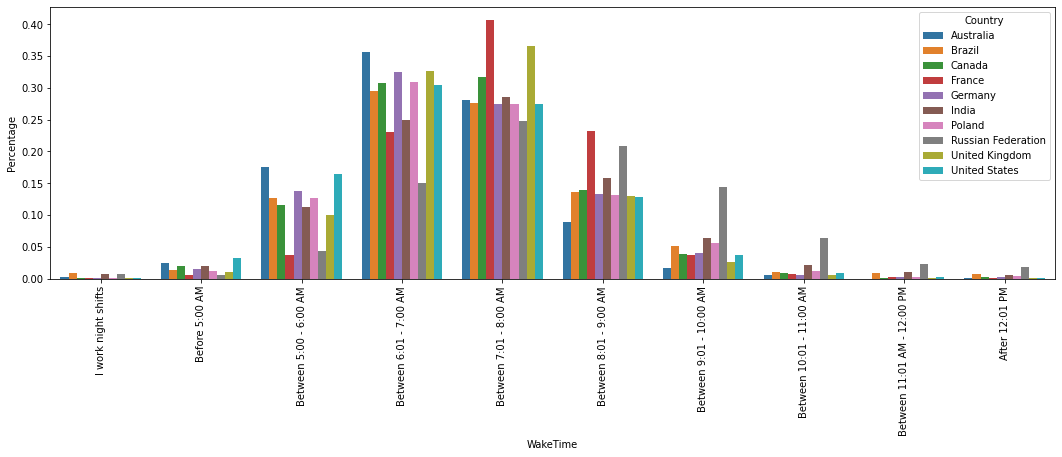

In [13]:
# Visualize percentages of top 10 countries with the most survey responses by wake time
sns.barplot(x='WakeTime', y='Percentage', order=ordered_wake_time, hue='Country', data=df_country_perc)
plt.xticks(rotation=90)
plt.show()

Australia developers wake up relatively early compared to developers in other countries as their percentages are obvious in the wake time 5-6 AM and 6-7 AM. France holds the lead in the wake time 7-8 AM and 8-9 AM, indicating most french developers are comfortable with waking up at 7-9 AM as I am. Also, it is interesting to see a fair size of developers in Russia like to wake up late since their percentages of wake up time after 8 AM can not be ignored.

## Q2 - Do people using different programming languages wake up at different times?

In [14]:
# For this question, we only consider the top 15 programming languages used by respondents
df_languages = df[list(np.sum(df[languages]).sort_values(ascending=False).index[:15])+['WakeTime']]\
                .groupby(['WakeTime']).agg('sum').reset_index().melt(id_vars='WakeTime')
df_languages.columns = ['WakeTime', 'Language', 'Count']
df_languages.head()

,WakeTime,Language,Count
0,After 12:01 PM,JavaScript,181.0
1,Before 5:00 AM,JavaScript,1105.0
2,Between 10:01 - 11:00 AM,JavaScript,673.0
3,Between 11:01 AM - 12:00 PM,JavaScript,246.0
4,Between 5:00 - 6:00 AM,JavaScript,6026.0


In [15]:
language_counts = df_languages.groupby('Language')['Count'].sum()
language_counts.sort_values(ascending=False)

Language
JavaScript    48808.0
HTML          47683.0
CSS           45349.0
SQL           39957.0
Java          31189.0
Bash/Shell    28624.0
Python        27340.0
C#            24028.0
PHP           21014.0
C++           17374.0
C             15632.0
TypeScript    12309.0
Ruby           7164.0
Swift          5594.0
Go             5095.0
Name: Count, dtype: float64

In [16]:
df_languages_perc = df_languages.groupby(['WakeTime', 'Language'])['Count']\
                     .sum().div(language_counts, level='Language').reset_index().rename(columns={'Count': 'Percentage'})
df_languages_perc.head()

,WakeTime,Language,Percentage
0,After 12:01 PM,Bash/Shell,0.003389
1,After 12:01 PM,C,0.005438
2,After 12:01 PM,C#,0.003121
3,After 12:01 PM,C++,0.005813
4,After 12:01 PM,CSS,0.004079


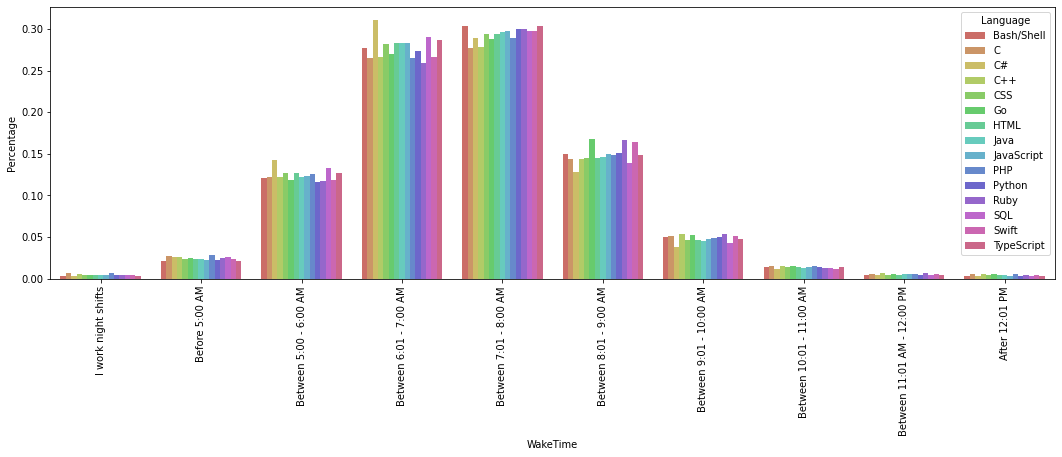

In [17]:
# Visualize wake up time by programming language
sns.barplot(x='WakeTime',
            y='Percentage', 
            order=ordered_wake_time, 
            hue='Language', 
            data=df_languages_perc, 
            palette=sns.color_palette("hls", 15))
plt.xticks(rotation=90)
plt.show()

All of the most popular programming languages have a similar distribution in wake up time. One of a few differences that can be noticed is developers using C# tend to wake up between 5-7 AM more than other developers.

## Q3 - Does wake up time have an effect on job satisfaction?

In [18]:
sat_counts = df.groupby('JobSatisfaction')['WakeTime'].count()
sat_counts

JobSatisfaction
Extremely dissatisfied                 2092
Extremely satisfied                   10961
Moderately dissatisfied                5521
Moderately satisfied                  22757
Neither satisfied nor dissatisfied     4179
Slightly dissatisfied                  6190
Slightly satisfied                     8701
Name: WakeTime, dtype: int64

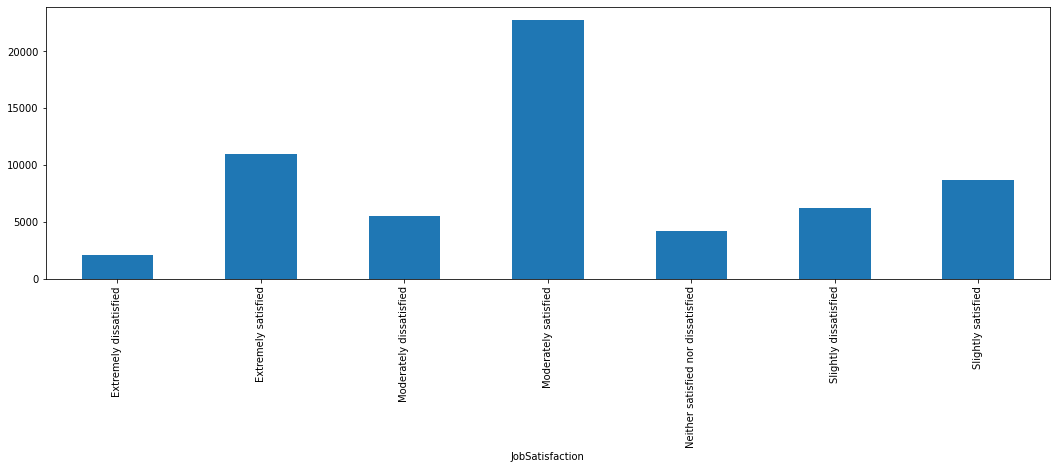

In [19]:
# Visualize Job Satisfaction Counts
sat_counts.plot(kind='bar')
plt.show()

In [20]:
df_sat_perc = df.groupby(['JobSatisfaction', 'WakeTime'])\
              .size().div(sat_counts, level='JobSatisfaction').reset_index().rename(columns={0: 'Percentage'})
df_sat_perc.head()

,JobSatisfaction,WakeTime,Percentage
0,Extremely dissatisfied,After 12:01 PM,0.005736
1,Extremely dissatisfied,Before 5:00 AM,0.043977
2,Extremely dissatisfied,Between 10:01 - 11:00 AM,0.013862
3,Extremely dissatisfied,Between 11:01 AM - 12:00 PM,0.007170
4,Extremely dissatisfied,Between 5:00 - 6:00 AM,0.138623


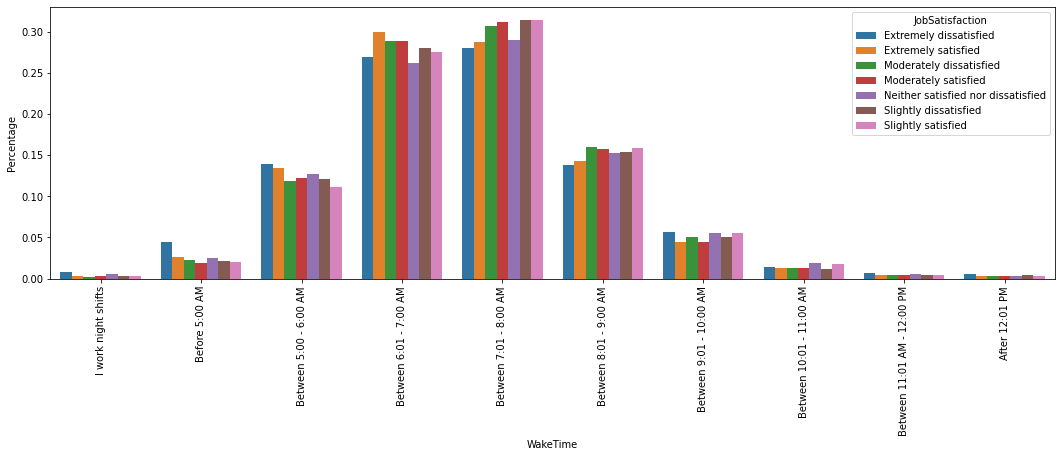

In [21]:
# Visualize job satisfaction by wake up time
sns.barplot(x='WakeTime', y='Percentage', order=ordered_wake_time, hue='JobSatisfaction', data=df_sat_perc)
plt.xticks(rotation=90)
plt.show()

Distributions of wake up time by job satisfaction look similar, showing that most developers are not forced to work at the time they don't want to. This also demonstrates either waking up early or waking up late does not have an impact on your work satisfaction. Therefore, maybe getting up at the time most comfortable to you is a good practice (as long as it does not mess with your work or study schedules).

## Q4 - Do people getting up at different times earn different?

In [22]:
# Data Preparation
# Create a new DataFrame for salary
# Because salary is numeric, to visualize it we need to bin the data
df_salary = df.dropna(subset=['WakeTime', 'ConvertedSalary'], axis=0).copy()
bins = [0, 5000, 15000, 25000, 40000, 60000, 80000, 100000, 150000, np.float("inf")]
b = pd.cut(df_salary['ConvertedSalary'].astype(float), bins)
df_salary.loc[:, 'binned_salary'] = b

In [23]:
salary_counts = df_salary.groupby('binned_salary')['WakeTime'].count()
salary_counts

binned_salary
(0.0, 5000.0]           2171
(5000.0, 15000.0]       5085
(15000.0, 25000.0]      3688
(25000.0, 40000.0]      5416
(40000.0, 60000.0]      7591
(60000.0, 80000.0]      6810
(80000.0, 100000.0]     4586
(100000.0, 150000.0]    6014
(150000.0, inf]         3879
Name: WakeTime, dtype: int64

In [24]:
df_salary_perc = df_salary.groupby(['binned_salary', 'WakeTime'])\
                     .size().div(salary_counts, level='binned_salary').reset_index().rename(columns={0: 'Percentage'})
df_salary_perc

,binned_salary,WakeTime,Percentage
0,"(0.0, 5000.0]",After 12:01 PM,0.007830
1,"(0.0, 5000.0]",Before 5:00 AM,0.048825
2,"(0.0, 5000.0]",Between 10:01 - 11:00 AM,0.017043
3,"(0.0, 5000.0]",Between 11:01 AM - 12:00 PM,0.007370
4,"(0.0, 5000.0]",Between 5:00 - 6:00 AM,0.146476
...,...,...,...
94,"(150000.0, inf]",Between 7:01 - 8:00 AM,0.292859
95,"(150000.0, inf]",Between 8:01 - 9:00 AM,0.143336
96,"(150000.0, inf]",Between 9:01 - 10:00 AM,0.040990
97,"(150000.0, inf]",I do not have a set schedule,0.025006


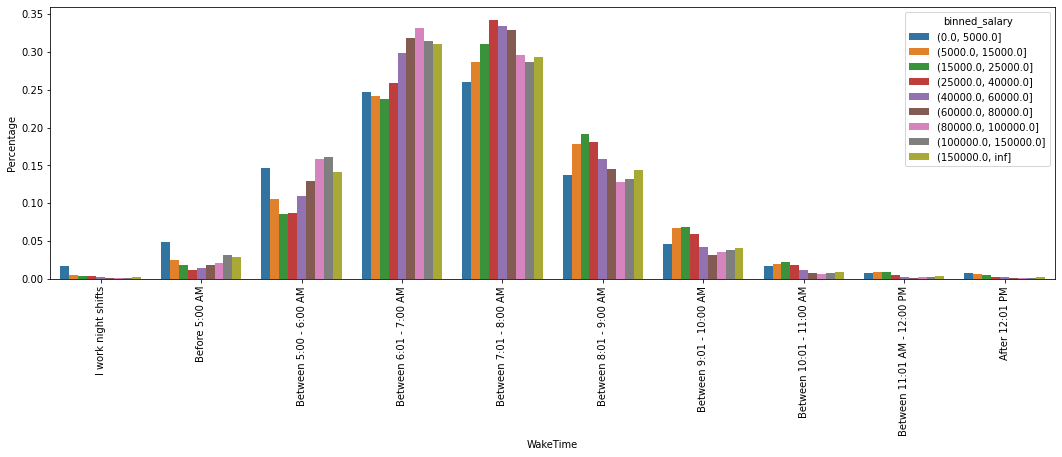

In [25]:
# Visualize percentage of binned salary in wake time
sns.barplot(x='WakeTime', y='Percentage', order=ordered_wake_time, hue='binned_salary', data=df_salary_perc)
plt.xticks(rotation=90)
plt.show()

Each salary range has a similar distribution tending toward 6-7 AM and 7-8 AM. It is not obvious that developers waking up early earn more or less than others. So we may conduct a hypothesis test to see if there is any difference.

### Hypothesis test

Whehter the salaries of developers who wake up between 6:01 - 7:00 AM earn more than developers who wake up between 5:00 - 6:00 AM.

In [26]:
# Generate series of each group for the test
df_salary.loc[:, 'ConvertedSalary'] = df_salary['ConvertedSalary'].astype(float)
salaries = df_salary[df_salary['WakeTime'] == 'Between 6:01 - 7:00 AM']['ConvertedSalary']
salaries_earlier = df_salary[df_salary['WakeTime'] == 'Between 5:00 - 6:00 AM']['ConvertedSalary']

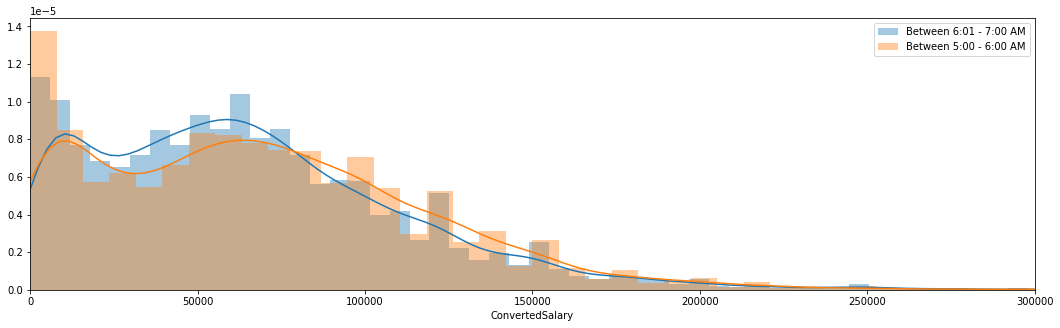

In [27]:
# Visualize the distributions of two groups to check whether t-test can be used
fig, ax = plt.subplots()
# limit salary range for better visualization
sns.distplot(salaries[salaries < 300000], ax=ax, label='Between 6:01 - 7:00 AM')
sns.distplot(salaries_earlier[salaries_earlier < 300000], ax=ax, label='Between 5:00 - 6:00 AM')
ax.set(xlim=(0, 300000))
ax.legend()
plt.show()

Distributions above show two groups are not normally distributed. Therefore, we may choose another method as the assumption of t-test cannot be satisfied.

Mann-Whitney U Test, which is a nonparametric statistical significance test, is used to do the test.

Group1: the developers who wake up between 6:01 - 7:00 AM

Group2: the developers who wake up between 5:00 - 6:00 AM

Null hypothesis H0: salaries of group 1 earn less than group 2.

Alternative hypothesis H1: salaries of group 1 does not earn less than group 2.

Significance level: 0.05

In [28]:
stat, p = mannwhitneyu(salaries, salaries_earlier, alternative='less')
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Fail to reject H0')
else:
    print('Reject H0')

Statistics=36301609.000, p=0.000
Reject H0


P values strongly suggests that the salaries of group 1 did not equal of fall below the salaries of group 2. Therefore, reject H0 and support the claim that the group 1 earn more than group 2.

I also want to add that the test result does not indicate any relationship between wake up time and salary, which means getting up early does not make you earn more and vice versa. I guess such result is caused by developer's occupation. Developers earning less than $5000 are more likely to be students, freelancers and startup founders. There is a higher proportion of developers who wake up early is in this group. And developers who have a stable salary prefer getting up at the normal working time.